In [1]:
import numpy as np
import rebound as rb
from matplotlib import pyplot as plt
import sympy as sp
import celmech as cm
from celmech.disturbing_function import get_fg_coefficients
from celmech.poisson_series import PoissonSeries,PSTerm

# get ttv posteriors

In [2]:
from resonantstate.data_download  import get_metadata_observations, download_observations_samples
from resonantstate.analyse_samples import *
from corner import hist2d

In [3]:
df_all_obs = get_metadata_observations()
target = "TRAPPIST-1"
df_selected = df_all_obs[df_all_obs["star_name"].isin([target])]

#download_destination_path = "downloaded_observtions_samples/"
download_destination_path = None
df_list = download_observations_samples(df_selected, download_destination_path)

In [4]:
for k,v in df_list[0].items():
    if k == "samples":
        print(f"{k}:\t...")
    else:
        print(f"{k}:\t{v}")
df = df_list[0]['samples']
df.head(3)

samples_name:	TRAPPIST-1_0
planets_list:	['TRAPPIST-1 b', 'TRAPPIST-1 c', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 h']
samples:	...
readme:	
2/18/2025

For TRAPPIST-1, we report the posterior parameters from a transit-timing
analysis assuming plane-parallel orbits for the planets as described
in Agol et al. (2021; A21).

The 447 measured times of transit and their uncertainties are given in Table
14 of A21.  The likelihood function is a Student's-t distribution for each
measured time of transit with the variance increased by a factor V_1, and the 
number of degrees of freedom specified as \nu, as described in section 4 of A21.

The bounds on model parameters are given in Table 13 of A21.
The prior on each eccentricity is 1/e since we are sampling in 
(e*cos(omega),e*sin(omega)).

The N-body model uses an earlier version of NbodyGradient.jl (Agol,
Hernandez & Langford 2021), which has source code in the TRAPPIST1_Spitzer 
github repository. Light trave

,sample_index,mean_longitude_deg_0,period_days_0,k_0,h_0,inclination_deg_0,longitude_of_ascending_node_deg_0,mass_planet_star_ratio_0,radius_planet_star_ratio_0,mean_longitude_deg_1,...,mean_longitude_deg_6,period_days_6,k_6,h_6,inclination_deg_6,longitude_of_ascending_node_deg_6,mass_planet_star_ratio_6,radius_planet_star_ratio_6,mass_star_m_sun,radius_star_r_sun
0,0.0,0.305904,1.510821,-0.003230,0.003517,90.0,2.911130e-33,0.000048,0.0859,172.556730,...,69.197595,18.773626,-0.004242,-0.000364,90.0,6.435094e-31,0.000011,0.05809,0.0898,0.1192
1,1.0,0.824545,1.510821,0.001239,0.003318,90.0,-2.328893e-32,0.000046,0.0859,173.074502,...,69.347179,18.773196,-0.002598,0.000994,90.0,-6.435110e-31,0.000010,0.05809,0.0898,0.1192
2,2.0,0.779496,1.510834,0.000764,0.005190,90.0,-1.746678e-32,0.000046,0.0859,172.558952,...,69.183522,18.773309,-0.003817,0.000364,90.0,-1.287024e-30,0.000010,0.05809,0.0898,0.1192


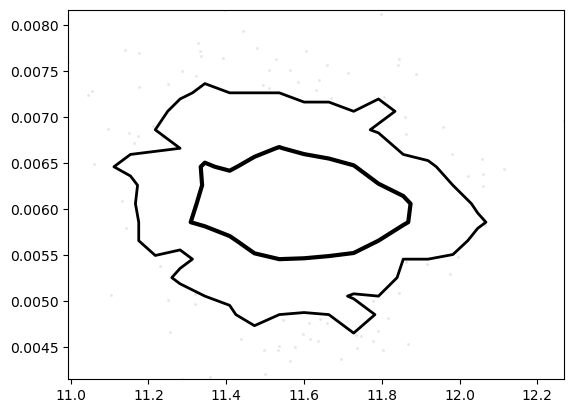

In [5]:
for i in range(df_list[0]['nb_planets']):
    df[f'z_{i}'] = df[f'k_{i}'] + 1j * df[f'h_{i}'] 

for i in range(df_list[0]['nb_planets']-1):
    pratio = df[f'period_days_{i+1}']/df[f'period_days_{i}']
    jres = int(np.round(1+1/(pratio.median()-1)))
    Delta = (jres-1)*pratio/jres - 1
    f,g = get_fg_coefficients(jres,1)
    denom = np.sqrt(f*f+g*g)
    df[f'Z_{i}_{i+1}'] = (f * df[f'z_{i}'] + df[f'z_{i+1}']) / denom

hist2d(
    df['mass_planet_star_ratio_4'].values/3e-6 , 
    np.abs(df['Z_3_4']).values,
    plot_density=False,
    levels=[0.68,0.95],
    contour_kwargs={'linewidths':[2,3]}
)

In [6]:
def row_to_rebound_sim(row,npl):
    DEG2RAD = np.pi / 180
    sim = rb.Simulation()
    sim.units = ('Msun','days','AU')
    Mstar = row['mass_star_m_sun']
    sim.add(m=Mstar)
    for i in range(npl):
        h,k = np.real((row[f'h_{i}'],row[f'k_{i}']))
        ecc = np.sqrt(h*h+k*k)
        pomega = np.arctan2(h,k)
        
        sim.add(
            m = row[f'mass_planet_star_ratio_{i}'] * Mstar,
            P = row[f'period_days_{i}'],
            e = ecc,
            inc = row[f'inclination_deg_{i}'] * DEG2RAD,
            l = row[f'mean_longitude_deg_{i}'] * DEG2RAD,
            pomega = pomega,
            Omega = row[f'longitude_of_ascending_node_deg_{i}'] * DEG2RAD
        )
    sim.move_to_com()

    return sim
    

In [7]:
sim = row_to_rebound_sim(df.iloc[0],df_list[0]['nb_planets'])
sim.integrator = 'whfast'
sim.ri_whfast.safe_mode = 0
sim.dt = sim.particles[1].P / 25.
Tfin = 5e4 * sim.particles[1].P
sim.save_to_file("tmp.sa",interval=Tfin / 256,delete_file=True)
sim.integrate(Tfin)

# dynamics

In [8]:
import requests
import pandas as pd
from io import StringIO


from resonant_chains import get_chain_rebound_sim
def get_chain_hpert(resonances, max_order,max_order_dl = 1):
    sim = get_chain_rebound_sim(resonances,masses)
    pvars = cm.Poincare.from_Simulation(sim)
    pham = cm.PoincareHamiltonian(pvars)
    periods = []
    period = 1
    periods.append(period)
    for j,k in resonances:
        period *= j/sp.S(j-k)
        periods.append(period)
    hpert_series_terms = []

    ei_order = lambda k,nu: np.sum(np.abs(k[2:])) + 2*np.sum(nu)
    for i1,p1 in enumerate(periods):
        for i2,p2 in zip(range(i1+1,len(periods)),periods[i1+1:]):
            pratio = p2/p1
            p,q = int(sp.numer(pratio)),int(sp.numer(pratio) - sp.denom(pratio))
            resonant_terms = cm.disturbing_function.list_resonance_terms(p,q,max_order = max_order)
            if len(resonant_terms)>0:
                print("adding terms for {}:{} MMR between {} and {}".format(p,p-q,i1+1,i2+1))
            for k,nu in resonant_terms:
                hpert_series_terms += cm.poisson_series.DFTerm_as_PSterms(pham,i1+1,i2+1,k,nu,(0,0))
                if ei_order(k,nu) <= max_order_dl:
                    hpert_series_terms += cm.poisson_series.DFTerm_as_PSterms(pham,i1+1,i2+1,k,nu,(1,0))
                    hpert_series_terms += cm.poisson_series.DFTerm_as_PSterms(pham,i1+1,i2+1,k,nu,(0,1))

    secular_terms = cm.disturbing_function.list_secular_terms(min_order=0,max_order = max_order)
    for k,nu in secular_terms:
        for i1 in range(1,sim.N):
            for i2 in range(i1+1,sim.N):
                hpert_series_terms += cm.poisson_series.DFTerm_as_PSterms(pham,i1,i2,k,nu,(0,0))
                if ei_order(k,nu) <= max_order_dl:
                    hpert_series_terms += cm.poisson_series.DFTerm_as_PSterms(pham,i1,i2,k,nu,(1,0))
                    hpert_series_terms += cm.poisson_series.DFTerm_as_PSterms(pham,i1,i2,k,nu,(0,1))
    return PoissonSeries.from_PSTerms(hpert_series_terms)
from celmech.nbody_simulation_utilities import add_canonical_heliocentric_elements_particle
import rebound as rb
import celmech as cm
def Deltas_to_pvars(Deltas,resonances,masses):
    sim = rb.Simulation()
    sim.add(m=1)
    Period = 1
    add_canonical_heliocentric_elements_particle(masses[0],{'a' : Period**(2/3)},sim)
    for Delta,mass,pq in zip(Deltas,masses[1:],resonances):
        p,q = pq
        Period *= (1+Delta)*p/(p-q)
        add_canonical_heliocentric_elements_particle(mass,{'a' : Period**(2/3)},sim)
    sim.move_to_com()

    return cm.Poincare.from_Simulation(sim)

In [9]:
periods = np.array([df[f'period_days_{i}'].median() for i in range(df_list[0]['nb_planets'])])
masses = np.array([df[f'mass_planet_star_ratio_{i}'].median() for i in range(df_list[0]['nb_planets'])])

# jres = np.round(1+1/(periods[1:]/periods[:-1]-1)).astype(int)
# resonances = [(j,1) for j in jres]
resonances = [(8,3),(5,2),(3,1),(3,1),(4,1),(3,1)]
Deltas_obs = [(jk[0]-jk[1])*p2/p1/jk[0]-1 for jk,p1,p2 in zip(resonances,periods[:-1],periods[1:])];

In [10]:
Deltas_obs

[0.00174143285830608, 0.003488707193743057, 0.004492602787972144, 0.006331927757686984, 0.006383946555192477, 0.01256417097757856]

# debug

In [15]:
from resonant_chains import ResonantChainPoissonSeries
from resonant_chains import resonant_chain_variables_transformation_matrix
from resonant_chains import transform_poincare_poisson_series
#from celmech.pois
Tmtrx = resonant_chain_variables_transformation_matrix(resonances[:2])


In [55]:
pvars = Deltas_to_pvars([0 for _ in range(3)],resonances,masses)

#rc = ResonantChainPoissonSeries(resonances[:1],masses[:2],hpert)

adding terms for 8:5 MMR between 1 and 2
adding terms for 5:3 MMR between 2 and 3


[(8, 3)]

In [72]:
def resonant_chain_variables_transformation_matrix(resonances):
    # number of planets
    N = len(resonances) + 1
    A = np.zeros((3*N,3*N))
    plast,qlast = resonances[-1]
    A[0,N-2:N] = 1,-1 #-1,1
    A[1,N-2] = (qlast - plast) #/ qlast
    A[1,N-1] = plast #/ qlast
    for i in range(N-2):
        resvec1,resvec2 = np.zeros((2,N),dtype=int)
        p1,q1 = resonances[i]
        p2,q2 = resonances[i+1]
        resvec1[i] = (q1 - p1) #/q1
        resvec1[i+1] = p1 #/q1
        resvec2[i+1] = (q2 - p2) #/ q2
        resvec2[i+2] = p2 #/ q2
        row = resvec2 - resvec1
        A[i+2,:N] = row #// np.gcd.reduce(row)
    A[N:,N-2] = (qlast - plast) #/ qlast
    A[N:,N-1] = plast #/ qlast
    A[N:,N:] = qlast * np.eye(2*N,dtype=int)
    # ensure det = 1
    #A  = np.array([row//np.gcd.reduce(row) for row in A],dtype=int)
    #A
    return A

hpert = get_chain_hpert(resonances[:3],3,0)
T = resonant_chain_variables_transformation_matrix(resonances[:3])

T
Tinv = np.linalg.inv(T)

adding terms for 8:5 MMR between 1 and 2
adding terms for 4:1 MMR between 1 and 4
adding terms for 5:3 MMR between 2 and 3
adding terms for 5:2 MMR between 2 and 4
adding terms for 3:2 MMR between 3 and 4


In [73]:
print(np.array2string(T))
print(np.array2string(Tinv))

[[  0.   0.   1.  -1.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  -2.   3.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  5. -11.   5.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   3.  -7.   3.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  -2.   3.   1.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  -2.   3.   0.   1.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  -2.   3.   0.   0.   1.   0.   0.   0.   0.   0.]
 [  0.   0.  -2.   3.   0.   0.   0.   1.   0.   0.   0.   0.]
 [  0.   0.  -2.   3.   0.   0.   0.   0.   1.   0.   0.   0.]
 [  0.   0.  -2.   3.   0.   0.   0.   0.   0.   1.   0.   0.]
 [  0.   0.  -2.   3.   0.   0.   0.   0.   0.   0.   1.   0.]
 [  0.   0.  -2.   3.   0.   0.   0.   0.   0.   0.   0.   1.]]
[[ 8.          1.93333333  0.2         0.73333333  0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 5.          1.33333333  0.          0.33333333  0.          0.
   0.          0.          0.       

In [74]:
Npl = hpert.M
[np.round(term.q @ Tinv[:Npl,:Npl]).astype(int) for term in hpert.terms]

[array([ 0,  1, -1, -1]),
 array([ 0, -1,  1,  1]),
 array([ 0,  1, -1, -1]),
 array([ 0, -1,  1,  1]),
 array([ 0,  1, -1, -1]),
 array([ 0, -1,  1,  1]),
 array([ 0,  1, -1, -1]),
 array([ 0, -1,  1,  1]),
 array([ 0,  1, -1, -1]),
 array([ 0, -1,  1,  1]),
 array([ 0,  1, -1, -1]),
 array([ 0, -1,  1,  1]),
 array([ 0,  1, -1, -1]),
 array([ 0, -1,  1,  1]),
 array([ 0,  1, -1, -1]),
 array([ 0, -1,  1,  1]),
 array([ 0,  1, -1, -1]),
 array([ 0, -1,  1,  1]),
 array([ 0,  1, -1, -1]),
 array([ 0, -1,  1,  1]),
 array([ 0,  2,  0, -1]),
 array([ 0, -2,  0,  1]),
 array([ 0,  2,  0, -1]),
 array([ 0, -2,  0,  1]),
 array([ 0,  2,  0, -1]),
 array([ 0, -2,  0,  1]),
 array([ 0,  2,  0, -1]),
 array([ 0, -2,  0,  1]),
 array([ 0,  2,  0, -1]),
 array([ 0, -2,  0,  1]),
 array([ 0,  2,  0, -1]),
 array([ 0, -2,  0,  1]),
 array([ 0,  2,  0, -1]),
 array([ 0, -2,  0,  1]),
 array([ 0,  2,  0, -1]),
 array([ 0, -2,  0,  1]),
 array([ 0,  2,  0, -1]),
 array([ 0, -2,  0,  1]),
 array([ 0, 

In [18]:
for term_pair in zip(hpert.terms[::2],hpert.terms[1::2]):
    series = PoissonSeries.from_PSTerms(term_pair)
    tseries = transform_poincare_poisson_series(Tmtrx,series)
    cleared = np.all(np.array([t.q[1] for t in tseries.terms])==0)
    if not cleared:
        display(series.as_expression(),tseries.as_expression())
        print()

                            3  ⅈ⋅(-5⋅\theta₁ + 8⋅\theta₂)                       3  ⅈ⋅(5⋅\theta₁ - 8⋅\theta₂)
- 0.132173834064288⋅\bar{z}₂ ⋅ℯ                           - 0.132173834064288⋅z₂ ⋅ℯ                         

                            3  -2⋅ⅈ⋅\theta₂                       3  2⋅ⅈ⋅\theta₂
- 0.132173834064288⋅\bar{z}₂ ⋅ℯ             - 0.132173834064288⋅z₂ ⋅ℯ           

                                   2  ⅈ⋅(-5⋅\theta₁ + 8⋅\theta₂)                          2  ⅈ⋅(5⋅\theta₁ - 8⋅\theta₂)
0.324423615542101⋅\bar{z}₁⋅\bar{z}₂ ⋅ℯ                           + 0.324423615542101⋅z₁⋅z₂ ⋅ℯ                         

                                   2  -2⋅ⅈ⋅\theta₂                          2  2⋅ⅈ⋅\theta₂
0.324423615542101⋅\bar{z}₁⋅\bar{z}₂ ⋅ℯ             + 0.324423615542101⋅z₁⋅z₂ ⋅ℯ           

                            2           ⅈ⋅(-5⋅\theta₁ + 8⋅\theta₂)                       2     ⅈ⋅(5⋅\theta₁ - 8⋅\theta₂)
- 0.264761286182727⋅\bar{z}₁ ⋅\bar{z}₂⋅ℯ                           - 0.264761286182727⋅z₁ ⋅z₂⋅ℯ                         

                            2           -2⋅ⅈ⋅\theta₂                       2     2⋅ⅈ⋅\theta₂
- 0.264761286182727⋅\bar{z}₁ ⋅\bar{z}₂⋅ℯ             - 0.264761286182727⋅z₁ ⋅z₂⋅ℯ           

                           3  ⅈ⋅(-5⋅\theta₁ + 8⋅\theta₂)                        3  ⅈ⋅(5⋅\theta₁ - 8⋅\theta₂)
0.0718768417125986⋅\bar{z}₁ ⋅ℯ                           + 0.0718768417125986⋅z₁ ⋅ℯ                         

                           3  -2⋅ⅈ⋅\theta₂                        3  2⋅ⅈ⋅\theta₂
0.0718768417125986⋅\bar{z}₁ ⋅ℯ             + 0.0718768417125986⋅z₁ ⋅ℯ           

                                     2  ⅈ⋅(-5⋅\theta₁ + 8⋅\theta₂)                          2  ⅈ⋅(5⋅\theta₁ - 8⋅\theta₂)
- 0.020976743019442⋅\bar{z}₂⋅\bar{z}₄ ⋅ℯ                           - 0.020976743019442⋅z₂⋅z₄ ⋅ℯ                         

                                     2  -2⋅ⅈ⋅\theta₂                          2  2⋅ⅈ⋅\theta₂
- 0.020976743019442⋅\bar{z}₂⋅\bar{z}₄ ⋅ℯ             - 0.020976743019442⋅z₂⋅z₄ ⋅ℯ           

                                    2  ⅈ⋅(-5⋅\theta₁ + 8⋅\theta₂)                           2  ⅈ⋅(5⋅\theta₁ - 8⋅\theta₂)
0.0158004886110961⋅\bar{z}₁⋅\bar{z}₄ ⋅ℯ                           + 0.0158004886110961⋅z₁⋅z₄ ⋅ℯ                         

                                    2  -2⋅ⅈ⋅\theta₂                           2  2⋅ⅈ⋅\theta₂
0.0158004886110961⋅\bar{z}₁⋅\bar{z}₄ ⋅ℯ             + 0.0158004886110961⋅z₁⋅z₄ ⋅ℯ           

                                               ⅈ⋅(-5⋅\theta₁ + 8⋅\theta₂)                                ⅈ⋅(5⋅\theta₁ - 8⋅\theta₂)
0.0443429003800492⋅\bar{z}₂⋅\bar{z}₃⋅\bar{z}₄⋅ℯ                           + 0.0443429003800492⋅z₂⋅z₃⋅z₄⋅ℯ                         

                                               -2⋅ⅈ⋅\theta₂                                2⋅ⅈ⋅\theta₂
0.0443429003800492⋅\bar{z}₂⋅\bar{z}₃⋅\bar{z}₄⋅ℯ             + 0.0443429003800492⋅z₂⋅z₃⋅z₄⋅ℯ           

                                                 ⅈ⋅(-5⋅\theta₁ + 8⋅\theta₂)                                ⅈ⋅(5⋅\theta₁ - 8⋅\theta₂)
- 0.0334007758873032⋅\bar{z}₁⋅\bar{z}₃⋅\bar{z}₄⋅ℯ                           - 0.0334007758873032⋅z₁⋅z₃⋅z₄⋅ℯ                         

                                                 -2⋅ⅈ⋅\theta₂                                2⋅ⅈ⋅\theta₂
- 0.0334007758873032⋅\bar{z}₁⋅\bar{z}₃⋅\bar{z}₄⋅ℯ             - 0.0334007758873032⋅z₁⋅z₃⋅z₄⋅ℯ           

                                      2  ⅈ⋅(-5⋅\theta₁ + 8⋅\theta₂)                           2  ⅈ⋅(5⋅\theta₁ - 8⋅\theta₂)
- 0.0234342005845775⋅\bar{z}₂⋅\bar{z}₃ ⋅ℯ                           - 0.0234342005845775⋅z₂⋅z₃ ⋅ℯ                         

                                      2  -2⋅ⅈ⋅\theta₂                           2  2⋅ⅈ⋅\theta₂
- 0.0234342005845775⋅\bar{z}₂⋅\bar{z}₃ ⋅ℯ             - 0.0234342005845775⋅z₂⋅z₃ ⋅ℯ           

                                   2  ⅈ⋅(-5⋅\theta₁ + 8⋅\theta₂)                          2  ⅈ⋅(5⋅\theta₁ - 8⋅\theta₂)
0.017651540046211⋅\bar{z}₁⋅\bar{z}₃ ⋅ℯ                           + 0.017651540046211⋅z₁⋅z₃ ⋅ℯ                         

                                   2  -2⋅ⅈ⋅\theta₂                          2  2⋅ⅈ⋅\theta₂
0.017651540046211⋅\bar{z}₁⋅\bar{z}₃ ⋅ℯ             + 0.017651540046211⋅z₁⋅z₃ ⋅ℯ           

IndexError: index 4 is out of bounds for axis 0 with size 4

# simpler model:  3:2, 3:2, 3:2 for inner 4 planets

In [31]:
from resonant_chains import ResonantChainPoissonSeries, newton_solve2

In [32]:
resonances = [(3,1) for _ in range(3)]
masses= masses[:4]

In [33]:
pvars = Deltas_to_pvars([0 for _ in range(3)],resonances,masses[:4])
hpert = get_chain_hpert(resonances,1,0)
rc = ResonantChainPoissonSeries(resonances,masses,hpert)

adding terms for 3:2 MMR between 1 and 2
adding terms for 3:2 MMR between 2 and 3
adding terms for 3:2 MMR between 3 and 4


In [34]:
gcds = []
for res1,res2, in zip(resonances,resonances[1:]):
    j1,k1 = res1
    j2,k2 = res2
    k3br = np.array([k1-j1,j1,0]) - np.array([0,k2-j2,j2])  
    print(k3br,np.gcd.reduce(k3br))
    gcds.append(np.gcd.reduce(k3br))
gcds = np.array(gcds)

rvars,dK2 = rc.pvars_to_real_vars(pvars)
guess = rvars
guess[rc.N_planar:rc.N_planar+rc.M] = np.pi / gcds 
rc.dK2 = dK2

eqC = newton_solve2(rc.planar_flow_and_jacobian,guess)

eigs = np.linalg.eigvals(rc.planar_jacobian(eqC))
print(np.all(np.isclose(np.real(eigs),0)))
Tmax = np.max(2*np.pi/np.imag(eigs))

[-2  5 -3] 1
[-2  5 -3] 1
True


In [35]:
from celmech.lie_transformations import FirstOrderGeneratingFunction
print("correcting...")
chi_static = FirstOrderGeneratingFunction(Deltas_to_pvars([0 for _ in jres],resonances,masses))
Npl = rc.N_planar
for i in range(1,Npl):
    chi_static.add_zeroth_order_term(i,i+1)    
    for k in range(1,5):
        chi_static.add_cosine_term(
            [jres[i-1]+k,1-jres[i-1]-k,-1,0,0,0],
            indexIn=i,
            indexOut=i+1
        )
        chi_static.add_cosine_term(
            [jres[i-1]-k,1-jres[i-1]+k,-1,0,0,0],
            indexIn=i,
            indexOut=i+1
        )
        chi_static.add_cosine_term(
            [jres[i-1]+k,1-jres[i-1]-k,0,-1,0,0],
            indexIn=i,
            indexOut=i+1
        )
        chi_static.add_cosine_term(
            [jres[i-1]-k,1-jres[i-1]+k,0,-1,0,0],
            indexIn=i,
            indexOut=i+1
        )
chi_static.mean_to_osculating()

correcting...


In [36]:
pvars_eq = rc.real_planar_vars_to_pvars(eqC)
[(j[0]-1)*pout.P / pin.P/j[0] - 1 for pin,pout,j in zip(pvars_eq.particles[1:],pvars_eq.particles[2:],resonances)]

[0.0015461604155977415, 0.0021183807295555024, 0.0029850355821141594]

In [41]:
from celmech.disturbing_function import get_fg_coefficients

guess = eqC.copy()
dK2vals = dK2 + np.linspace(0.01,-0.01,100)
eqsC = np.zeros((dK2vals.size,guess.size))
freqs = np.zeros((dK2vals.size,guess.size//2))
eccs = np.zeros((dK2vals.size,rc.N_planar))
Periods = np.zeros((dK2vals.size,rc.N_planar))
Z = np.zeros((dK2vals.size,rc.N_planar-1))
f_res,g_res = np.transpose([get_fg_coefficients(j,k) for j,k in resonances])

for i,dK2val in enumerate(dK2vals):
    rc.dK2 = dK2val
    guess = newton_solve2(rc.planar_flow_and_jacobian,guess)
    eqsC[i] = guess
    jac = rc.planar_jacobian(guess)
    eigs = np.linalg.eigvals(jac)
    freq = np.sort(np.imag(eigs))
    freqs[i] = freq[freq.size//2:]
    pvars = rc.real_planar_vars_to_pvars(guess)
    eccs[i] = [p.e for p in pvars.particles[1:]]
    Periods[i] = [p.P for p in pvars.particles[1:]]
    for l,jk in enumerate(resonances):
        pin = pvars.particles[1+l]
        pout = pvars.particles[2+l]
        zin = pin.e * np.exp(1j * pin.pomega)
        zout = pout.e * np.exp(1j * pout.pomega)
        Z[i,l] = np.abs((f_res[l] * zin + g_res[l] * zout) / np.sqrt(f_res[l] ** 2 + g_res[l] ** 2))

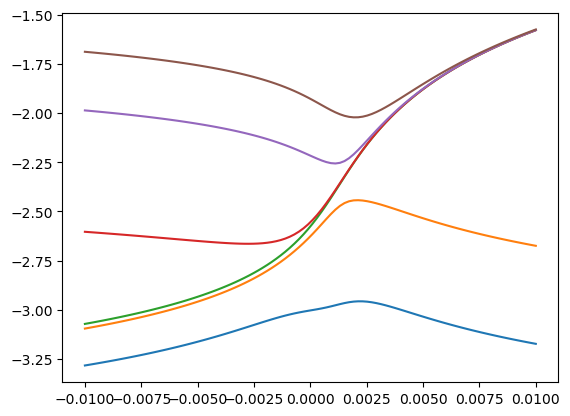

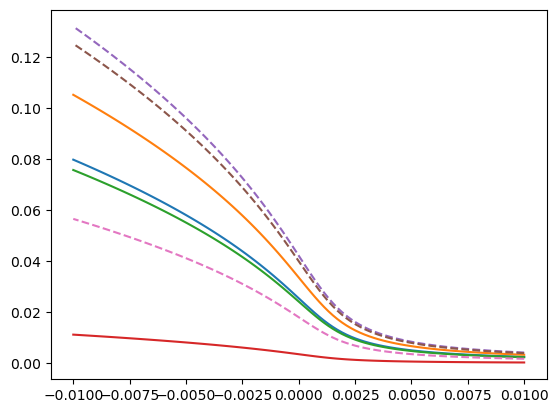

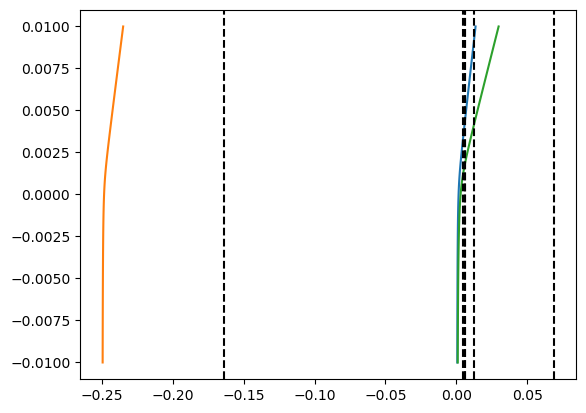

In [42]:
plt.plot(dK2vals,np.log10(freqs))
plt.figure()
plt.plot(dK2vals,eccs)
plt.plot(dK2vals,Z,ls='--')
#plt.axhline(0.026,ls='--',color='k')

Deltas = np.array([(j-1)*p2/p1/j-1 for p2,p1,j in zip(Periods.T[1:],Periods.T[:-1],jres)])

plt.figure()
plt.plot(Deltas.T,dK2vals)
for d in Deltas_obs:
    plt.axvline(d,color='k',ls='--')


# ttv solution simulation

In [62]:
np.median(results['e'][3])

0.0024855671387365727

In [67]:
i_eq = np.argmin(np.abs(Deltas[3,:] - 0.02))

In [73]:
Deltas

array([[0.01297413, 0.01242323, 0.01187288, 0.01132309, 0.01077385,
        0.01022519, 0.00967711, 0.00912964, 0.00858279, 0.0080366 ,
        0.00749111, 0.00694637, 0.00640248, 0.00585955, 0.00531777,
        0.00477743, 0.00423899, 0.00370324, 0.00317162, 0.00264687,
        0.00213466, 0.0016474 , 0.00121134, 0.00086754, 0.00063863,
        0.00050068, 0.0004172 , 0.00036446, 0.00033002, 0.00030816],
       [0.01294158, 0.01239526, 0.01184929, 0.01130365, 0.01075838,
        0.01021346, 0.00966893, 0.00912478, 0.00858106, 0.00803777,
        0.00749498, 0.00695272, 0.00641109, 0.0058702 , 0.00533022,
        0.00479144, 0.00425431, 0.0037196 , 0.0031887 , 0.00266432,
        0.00215203, 0.00166408, 0.00122655, 0.00088042, 0.00064863,
        0.00050768, 0.00042124, 0.0003655 , 0.00032772, 0.0003008 ],
       [0.019288  , 0.01847214, 0.01765664, 0.01684151, 0.01602678,
        0.01521244, 0.01439854, 0.01358509, 0.01277213, 0.0119597 ,
        0.01114789, 0.01033676, 0.00952646, 0.

In [78]:
results['z'] = results['e']*np.exp(1j * results['pomega'])
for j,z1,z2 in zip(jres,results['z'][:-1],results['z'][1:]):
    f,g = get_fg_coefficients(j,1)
    Z = f*z1 + g*z2
    Z /= np.sqrt(f*f+g*g)

KeyError: 'z'

In [43]:
phi_eq_predict = eqsC[0,rc.N_planar:rc.N_planar+4]

(0.0, 443.2048968290691)

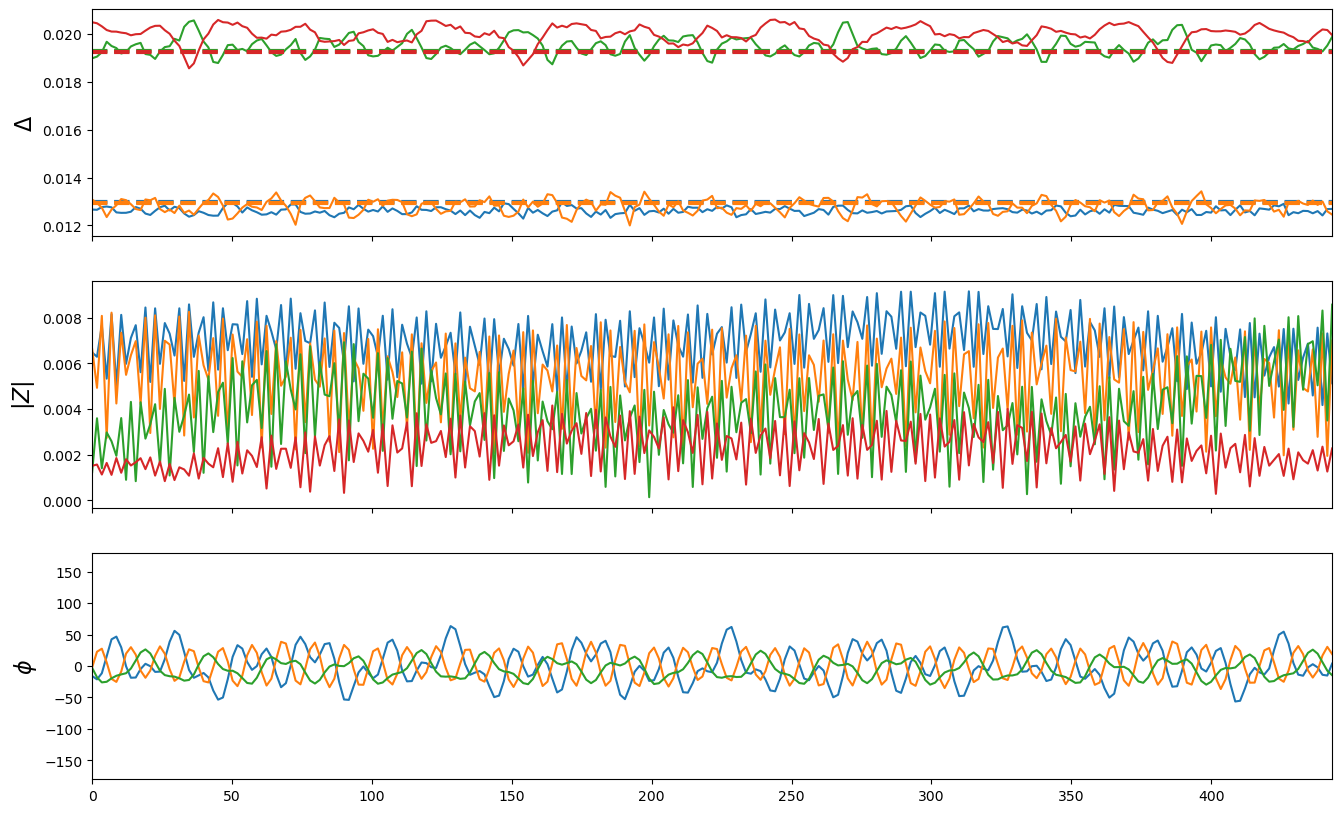

In [80]:
fig,ax = plt.subplots(3,1,sharex=True,figsize=(16,10),sharey='row')
# ax_list[0,0].set_title("Without mean-to-osculating correction",fontsize=16)
# ax_list[0,1].set_title("With mean-to-osculating correction",fontsize=16)
finame = "tmp.sa"

results = cm.nbody_simulation_utilities.get_simarchive_integration_results(finame,coordinates='heliocentric')
time_yrs = results['time'] / 365.35
for k,j,p1,p2 in zip(range(1000),jres,results['P'][:-1],results['P'][1:]):
    D = (j-1)*p2/p1/j-1
    l,=ax[0].plot(time_yrs,D)
    ax[0].axhline(Deltas[k,i_eq],color=l.get_color(),lw=3,ls='--')
    
# for j,ecc in enumerate(results['e']):
#     l,=ax[1].plot(time_yrs,ecc)
#     ax[1].axhline(eccs[i_eq,j],color=l.get_color(),lw=3,ls='--')
results['z'] = results['e']*np.exp(1j * results['pomega'])
for j,z1,z2 in zip(jres,results['z'][:-1],results['z'][1:]):
    f,g = get_fg_coefficients(j,1)
    Z = f*z1 + g*z2
    Z /= np.sqrt(f*f+g*g)
    l,=ax[1].plot(time_yrs,np.abs(Z))
    
mymod = lambda x: np.mod(x+np.pi,2*np.pi)-np.pi
for phi_pred,row in zip(phi_eq_predict,rc.Tmtrx[2:2+rc.M,:rc.N_planar]):
    phi = mymod(row @ results['l'] - phi_pred)
    ax[2].plot(time_yrs,180*phi/np.pi)

ax[0].set_ylabel(r'$\Delta$',fontsize=16)
ax[1].set_ylabel(r'$|Z|$',fontsize=16)
ax[2].set_ylabel(r'$\phi$',fontsize=16)

ax[2].set_ylim(-180,180)
ax[2].set_xlim(0,time_yrs[-1])

# compare simulations

In [42]:
from scipy.interpolate import interp1d


i_eq = np.argmin(np.abs(dK2vals - interp1d(Z[:,0],dK2vals,fill_value='extrapolate')(0.01)))

eqC = eqsC[i_eq]
dK2i = dK2vals[i_eq]
rc.dK2 = dK2i

pvars = rc.real_planar_vars_to_pvars(eqC)
sim_eq = pvars.to_Simulation()
sim_eq.integrator='whfast'
sim_eq.dt = sim_eq.particles[1].P / 25.
Tfin = 15 * Tmax
sim_eq.save_to_file("toi-178",interval=Tfin/256,delete_file=True)
print("integrating...")
sim_eq.integrate(Tfin)

#
print("correcting again...")
pvars = rc.real_planar_vars_to_pvars(eqC)
pvars.values = chi_static.mean_to_osculating_state_vector(rc.real_planar_vars_to_pvars(eqC).values)

sim_eq=pvars.to_Simulation()
sim_eq.integrator='whfast'
sim_eq.dt = sim_eq.particles[1].P / 25.
Tfin = 15 * Tmax
sim_eq.save_to_file("toi-178_cc",interval=Tfin/256,delete_file=True)
print("integrating...")
sim_eq.integrate(Tfin)


integrating...
correcting again...
integrating...


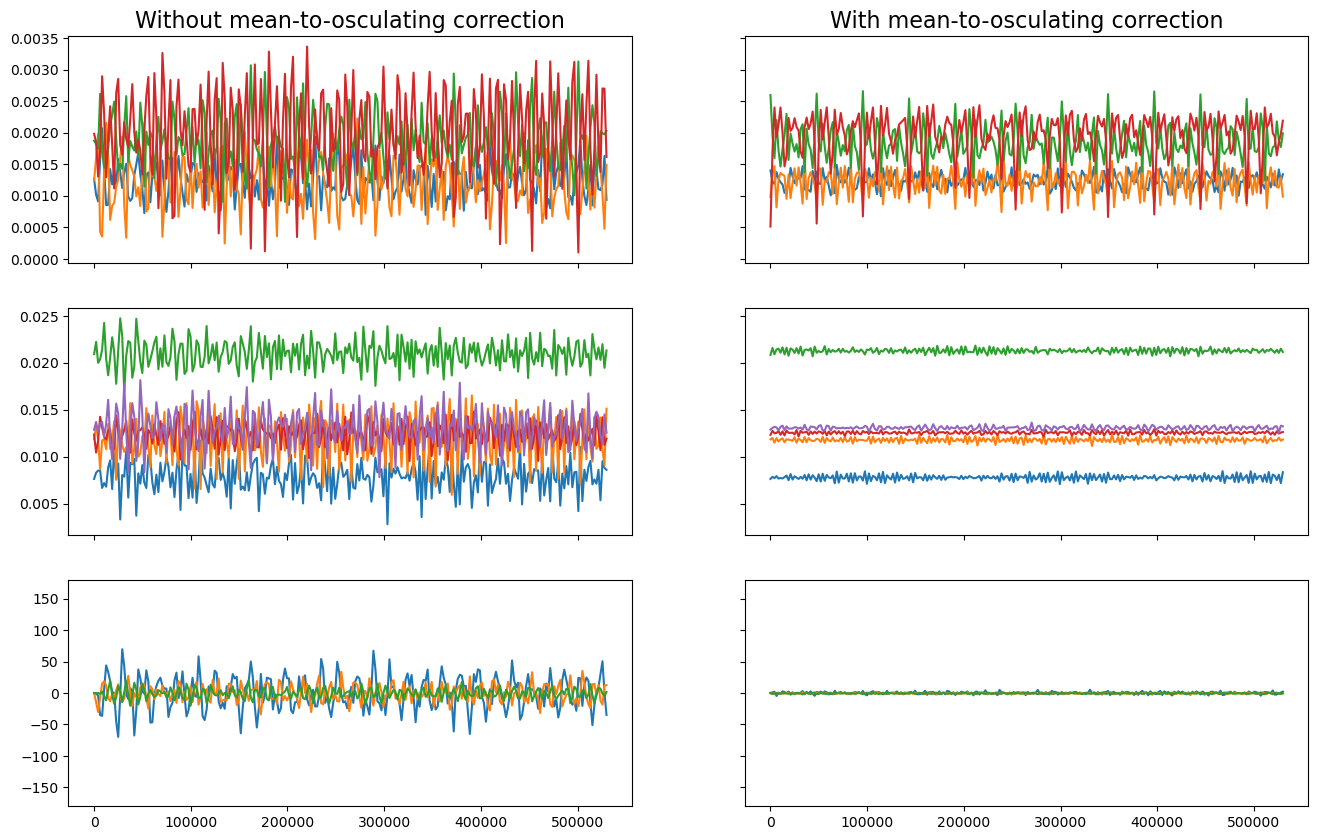

In [43]:
fig,ax_list = plt.subplots(3,2,sharex=True,figsize=(16,10),sharey='row')
ax_list[0,0].set_title("Without mean-to-osculating correction",fontsize=16)
ax_list[0,1].set_title("With mean-to-osculating correction",fontsize=16)
for finame,ax in zip(("kepler-223","kepler-223_cc"),ax_list.T):
    results = cm.nbody_simulation_utilities.get_simarchive_integration_results(finame,coordinates='heliocentric')
    for j,p1,p2 in zip(jres,results['P'][:-1],results['P'][1:]):
        D = (j-1)*p2/p1/j-1
        ax[0].plot(results['time'],D)
    for ecc in results['e']:
        ax[1].plot(results['time'],ecc)

    mymod = lambda x: np.mod(x+np.pi,2*np.pi)-np.pi
    for row in rc.Tmtrx[2:2+rc.M,:rc.N_planar]:
        phi = mymod(row @ results['l'] - (row @ results['l'])[0])
        ax[2].plot(results['time'],180*phi/np.pi)
    ax[2].set_ylim(-180,180)

In [44]:
for eq,finame,dK2 in zip(eqsC,[f"toi-178_sim_dK2_{v:.5f}" for v in dK2vals],dK2vals):
    pvars = rc.real_planar_vars_to_pvars(eq,dK2 = dK2)
    pvars.values = chi_static.mean_to_osculating_state_vector(pvars.values)
    sim=pvars.to_Simulation()
    sim.save_to_file(finame + ".bin",delete_file=True)

In [45]:
import rebound as rb
from matplotlib import pyplot as plt
import celmech as cm

# dissipative dynamics

In [46]:
from resonant_chains import tau_alphas_to_tau_as

In [47]:
def planar_dissipation_jacobian_symbolic(self,X,p=1):
    #
    # X = y_1,...,y_N,kappa_2,phi_1,...,phi_M,x_1,...,x_N,dK2,Phi_1,...,Phi_M
    #
    # dlna/dt = -1/tau_m - 2 p e^2/tau_e

    Ndim = 2*(self.M+self.N_planar+1)
    Npl = self.N_planar
    tau_e = [1/g for g in sp.symbols("gamma_e(1:{})".format(Npl+1),real=True)]
    rho = self.Lambda0s/self.Lambda0s[0]
    dis_jac = np.zeros((Ndim,Ndim),dtype=object)
    D_gamma_a = np.zeros((Npl,Ndim),dtype=object)

    Tinv_transpose = self.Tmtrx_inv.T

    nu_vec = Tinv_transpose[0,:Npl]
    for i in range(Npl):
        i_x = i+Npl+self.M+1
        D_gamma_a[i,i] = 4 * p * X[i] / tau_e[i] / rho[i]
        D_gamma_a[i,i_x] = 4 * p * X[i_x] / tau_e[i] / rho[i]

    K1_by_L10 = nu_vec @ rho
    D_K1_by_L10 = -0.5 * (rho * nu_vec) @ D_gamma_a

    for i,a_i in enumerate(Tinv_transpose[1:self.M+2,:Npl]):   
        i_P = 2 * Npl + self.M + 1 + i
        dis_jac[i_P] += -0.5 * rho * a_i @ D_gamma_a / K1_by_L10
        dis_jac[i_P] += -1 * (a_i @ rho) * D_K1_by_L10 / (K1_by_L10**2)
    dis_jac *= nu_vec @ rho

    i_dK2 = 2 * Npl + self.M+1
    for i in range(Npl):
        gamma_e = 1/tau_e[i]
        dis_jac[i,i] += -1 * gamma_e
        i_x = i+Npl+self.M+1
        dis_jac[i_x,i_x] += -1 * gamma_e
        # dK2
        dis_jac[i_dK2,i] += 2 * gamma_e * X[i]
        dis_jac[i_dK2,i_x] += 2 * gamma_e * X[i_x]
    return dis_jac

In [48]:
i_kappa2 = rc.N_planar 
i_dK2    = 2 * rc.N_planar + rc.M
rc.dK2 = dK2vals[i_eq]

In [49]:
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

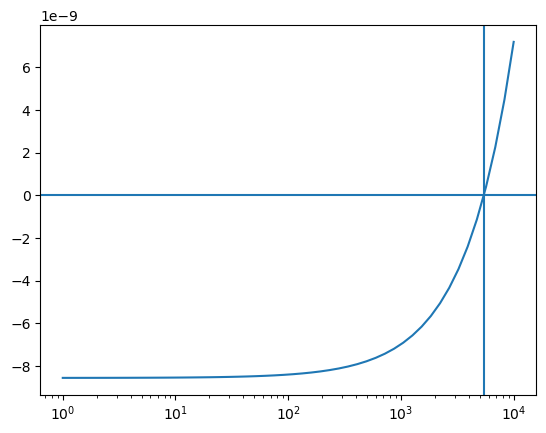

In [60]:
tau_as = np.ones(rc.N_planar) * 1e8
tau_as[0] = np.inf
tau_alphas = 1/(1/tau_as[0]-1/tau_as[1:])
tau_as_new = tau_alphas_to_tau_as(tau_alphas,masses,resonances)

x0 = np.insert(eqsC[i_eq],[-rc.M],[dK2vals[i_eq]])
Kvals=np.geomspace(1,10_000,50)
f_of_K = np.zeros(Kvals.size)
f_of_K_zerop = np.zeros(Kvals.size)
for i,K in enumerate(Kvals):
    tau_es = np.ones(rc.N_planar) * 1e8 / K
    tau_es[1:] = np.inf
    f_of_K[i] = rc.planar_flow_with_dissipation(x0,tau_es,tau_as,1)[-rc.M-1]
plt.plot(Kvals,f_of_K)
plt.axhline(0)
plt.xscale('log')
Keq_estimate = 10**interp1d(f_of_K,np.log10(Kvals))(0)    
tau_es = np.ones(rc.N_planar) * 1e8 / Keq_estimate
tau_es[1:] = np.inf

plt.axvline(Keq_estimate)


In [61]:
tau_alphas = 1/(1/tau_as[0]-1/tau_as[1:])
tau_as_new = tau_alphas_to_tau_as(tau_alphas,masses,resonances)
eq_dis = newton_solve2(
    lambda y: rc.planar_flow_and_jacobian_with_dissipation(y,tau_es,tau_as_new,1),
    x0
)
print((x0[i_dK2]-eq_dis[i_dK2])/x0[i_dK2])
j = rc.planar_jacobian_with_dissipation(eq_dis,tau_es,tau_as_new,1)
eig_rates = np.sort(np.real(np.linalg.eigvals(j)))
Tmax=1/np.max(eig_rates)
Tmax



0.004696303657024139


-4221460.435266886

In [62]:
j_cons = rc.planar_jacobian_with_dissipation(x0,np.inf * tau_es,np.inf * tau_as_new, 1)
vals,vecsT = np.linalg.eig(j_cons)
vecs = vecsT.T
covecs = np.linalg.inv(vecsT)

In [63]:
import numpy as np

def zero_small_values(arr, factor, *, copy=False):
    """
    Zero-out entries that are a given factor smaller (in absolute value)
    than the largest magnitude element in a NumPy array.

    Parameters
    ----------
    arr : np.ndarray
        Input array (any shape, real or complex).
    factor : float
        Threshold factor in (0, 1].  Elements whose absolute value is
        strictly less than ``factor * max(abs(arr))`` are set to zero.
        • factor = 1   ➔ only the maximum-magnitude element is kept  
        • factor ≈ 0  ➔ almost everything is kept
    copy : bool, optional
        If ``True`` return a modified *copy* and leave the original
        unchanged.  If ``False`` (default) the operation is in-place.

    Returns
    -------
    np.ndarray
        The thresholded array (same object as ``arr`` unless ``copy=True``).

    Example
    -------
    >>> x = np.array([1e-3, 2, -0.5, 10])
    >>> zero_small_values(x, 0.1)        # in-place
    >>> x
    array([0.   , 2.   , 0.   , 10.  ])
    """
    if not (0 < factor <= 1):
        raise ValueError("factor must be in the interval (0, 1].")

    target = arr.copy() if copy else arr
    max_abs = np.abs(target).max()          # largest magnitude
    cutoff  = factor * max_abs
    mask    = np.abs(target) < cutoff
    target[mask] = 0
    return target


$\tau_\mathrm{wave} = \frac{M_*}{m_p}\frac{M_*}{\Sigma a_p^2}h^4n_p^{-1}$

In [64]:
chain_sim = get_chain_rebound_sim(resonances,masses)

In [67]:
j_dis_symb = planar_dissipation_jacobian_symbolic(
    rc,
    np.insert(x0,i_kappa2,0)
)
j_dis_symb = np.delete(np.delete(j_dis_symb,i_kappa2,axis=0),i_kappa2,axis=1)

sigma = -1.5
gamma_wave = np.array([p.m * p.a**(2+sigma) * p.n for p in chain_sim.particles[1:]])
gamma_wave /= gamma_wave[0]
gamma_wave

for vec,vec_c,covec,val in zip(vecs[::2],vecs[1::2],covecs[::2],vals[::2]):
    exprn = sp.re(covec@j_dis_symb@vec)
    coeffs = np.array([exprn.coeff(g) for g in sp.symbols("gamma_e(1:{})".format(Npl+1),real=True)],dtype=float)
    zero_small_values(coeffs,1e-3)
    if np.any(coeffs>0):
        
        print("{:.5f}".format(np.imag(val)))
        print(np.array2string(coeffs,precision=3))
        angle_amps = np.real(vec[rc.N_planar:rc.N_planar+rc.M]+vec_c[rc.N_planar:rc.N_planar+rc.M])
        print(np.array2string(angle_amps,precision=3))
        rate_typeI = gamma_wave @ coeffs
        print("{:.5f}".format(rate_typeI))
        print()

0.00257
[-0.007  0.001 -0.014 -0.019 -0.013]
[-1.333  1.445 -0.365]
-0.02679

0.00225
[-0.004  0.001 -0.035 -0.016 -0.227]
[-1.564  0.633  0.977]
-0.08405

0.00175
[-0.081  0.004 -0.147 -0.157 -0.029]
[ 1.91   0.486 -0.331]
-0.23698

0.00035
[-0.256  0.006 -0.087 -0.116 -0.079]
[-1.969 -0.327 -0.122]
-0.37646



# choose $\tau_e\propto \tau_\mathrm{wave}$

In [38]:
Tmax/1e7

0.5782139559823394

600220.5408692237

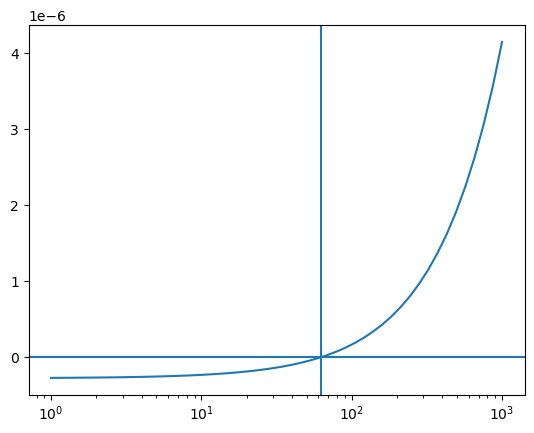

In [39]:
gamma_wave

tau_as = np.ones(rc.N_planar) * 1e6
tau_as[0] = np.inf
tau_alphas = 1/(1/tau_as[0]-1/tau_as[1:])
tau_as_new = tau_alphas_to_tau_as(tau_alphas,masses,resonances)

x0 = np.insert(eqsC[i_eq],[-rc.M],[dK2vals[i_eq]])
Kvals=np.geomspace(1,1_000,50)
f_of_K = np.zeros(Kvals.size)
f_of_K_zerop = np.zeros(Kvals.size)
for i,K in enumerate(Kvals):
    tau_es =  1e6 / K / gamma_wave
    f_of_K[i] = rc.planar_flow_with_dissipation(x0,tau_es,tau_as,1)[-rc.M-1]
plt.plot(Kvals,f_of_K)
Keq_estimate = 10**interp1d(f_of_K,np.log10(Kvals))(0)    

tau_es = 1e6 / Keq_estimate / gamma_wave


plt.axvline(Keq_estimate)
plt.axhline(0)
plt.xscale('log')


eq_dis = newton_solve2(
    lambda y: rc.planar_flow_and_jacobian_with_dissipation(y,tau_es,tau_as_new,1),
    x0
)
assert np.isclose(x0[i_dK2],eq_dis[i_dK2],rtol=1e-2)
j = rc.planar_jacobian_with_dissipation(eq_dis,tau_es,tau_as_new,1)
eig_rates = np.sort(np.real(np.linalg.eigvals(j)))
Tmax=1/np.max(eig_rates)
Tmax



In [42]:
tau_as_new,tau_es

(array([-1630015.53936419,  2587262.43643006,  2587262.43643006,
         2587262.43643006]),
 array([16028.28057524, 28171.29756299, 23531.52651953, 47506.97337476]))

In [ ]:
import reboundx as rbx

pv = rc.real_planar_vars_to_pvars(
    np.delete(eq_dis,-rc.M-1),
    dK2=eq_dis[-rc.M-1]
)
sim = pv.to_Simulation()
extras = rbx.Extras(sim)
mod = extras.load_operator('modify_orbits_direct')
mod.params['p']=1
extras.add_operator(mod)
for tau_e,tau_a,p in zip(tau_es,tau_as_new,sim.particles[1:]):
    p.params['tau_e'] = -1*tau_e
    p.params['tau_a'] = -1*tau_a
sim.integrator='whfast'
sim.dt = sim.particles[1].P/30
Tfin = 5 * Tmax

sim.save_to_file("kepler-223_migration.sa",interval = Tfin  / 512,delete_file = True)
sim.integrate(Tfin)

In [47]:
results = cm.nbody_simulation_utilities.get_simarchive_integration_results(
    "kepler-223_migration.sa",
    coordinates='heliocentric'
)

(-180.0, 180.0)

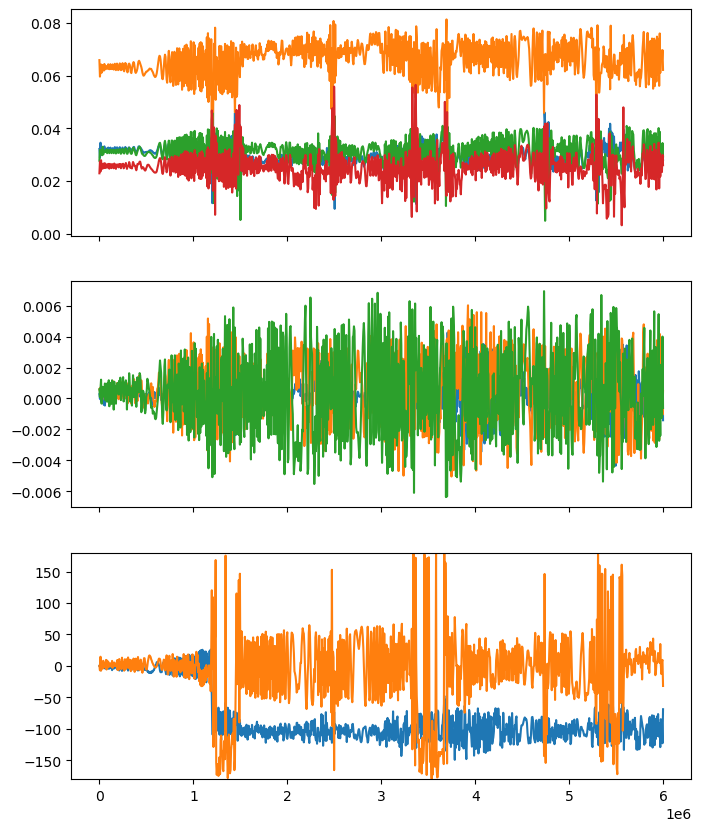

In [48]:
fig,ax = plt.subplots(3,1,sharex=True,figsize=(8,10))

for i in range(rc.N_planar):
    ax[0].plot(results['time'],results['e'][i])

for i in range(rc.N_planar-1):
    P1,P2 = results['P'][i],results['P'][i+1]
    j = resonances[i][0]
    Delta = (j-1)*P2/P1/j - 1
    ax[1].plot(results['time'],Delta)
    
for i in range(rc.M):
    phi = rc.Tmtrx[2+i,:rc.N_planar]@results['l']
    phi0 = eq_dis[rc.N_planar+i]
    phi = mymod(phi - phi0)
    ax[2].plot(results['time'],180*phi/np.pi)
ax[2].set_ylim(-180,180)